# Marine Heatwaves forecasting using NMME (North American Multi-Model Ensemble)

## Predicting marine heatwaves
Using the NMME (North American Multi-Model Ensemble), [Jacox et al., 2022](http://doi.org/10.1038/s41586-022-04573-9) demonstrate the possibility of predicting the marine heatwaves under a monthly time scale with the lead time up to a year. 
The [marine heatwaves portal](https://psl.noaa.gov/marine-heatwaves/) forecast hosted at NOAA/PSL website is based on the calculation show in this notebook.

### Goals in the notes 
- [Lazy loading](lazyLoading) the NMME model data from [IRI/LDEO Climate Data Library](http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/)
- Calculate the ensemble mean climatology for each model based on hindcast
- Calculate the SST anomaly in the forecast
- Calculate the threshold based on the SST anomaly
- Calculate the marine heatwave in the forecast
- Show result

```{note}
The following example is based on the paper [Jacox et al., 2022](http://doi.org/10.1038/s41586-022-04573-9). 
```

## Extract the data from the IRI/LDEO Climate Data Library OPeNDAP server
In this notebook, we demonstrate how to use the [NMME model](https://www.cpc.ncep.noaa.gov/products/NMME/) to generate the marine heatwaves prediction.
The dataset is currently hosted on [IRI/LDEO Climate Data Library](http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/).

```{tip}
The OPeNDAP server on the [IRI/LDEO Climate Data Library](http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/) also has a data extraction limit. 
For solving some of the limit issues, there are some great discussions on this [GitHub issue](https://github.com/pangeo-data/pangeo/issues/767).
To summarize, user sometime will need to play a bit on the chunk size to find the optimal download scheme.
```



### Import needed python package

In [1]:
import warnings
import cftime
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar

In [2]:
warnings.simplefilter("ignore")

```{tip}
This line of code is not affecting the execution but just removing some warning outputs that might clutter your notebook. 
However, do pay attention to some of the warnings since they will indicate some deprecation of function and arg/kwarg in future software updates.
```

## Lazy loading the NMME model data from IRI/LDEO Climate Data Library
Like in the previous notebook, we request the metadata from the OPeNDAP server to quickly check the data structure.
Four models provide forecasts till the current and hindcast at the time of generating this notebook.
Here, we only request one model `GFDL-SPEAR` for demonstration. 
However, for a better prediction, it is always better to have an ensemble of models with each model having its multiple runs.

In [3]:
#### The opendap access
model_list = ['GFDL-SPEAR']
forecast_list = ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.%s/.FORECAST/.MONTHLY/.sst/dods'%model for model in model_list] 

hindcast_list = ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.%s/.HINDCAST/.MONTHLY/.sst/dods'%model for model in model_list] 

The code generates a list of URLs to query with the OPeNDAP server for both hindcast and forecast.
With the URL generated, we can now send the query with `xr.open_dataset()`

In [4]:
# hindcast opendap
dict_model_hindcast = {}
for nmodel,link in enumerate(hindcast_list):
    dict_model_hindcast[model_list[nmodel]] = xr.open_dataset(link, engine='pydap',chunks={'M':1,'L':1,'S':1},decode_times=False)

In [5]:
# forecast opendap
dict_model_forecast = {}
for nmodel,link in enumerate(forecast_list):
    dict_model_forecast[model_list[nmodel]] = xr.open_dataset(link, engine='pydap',chunks={'M':1,'L':1,'S':1},decode_times=False)

Notice the `decode_times` is set to `False` due to the time unit being 'months since 1960-01-01' in the NMME dataset which is not following the [cf-convention](https://cfconventions.org/cf-conventions/cf-conventions.html#time-coordinate) of month and year should not be used in the time unit.
Therefore, `xr.open_dataset()` cannot decode the time coordinate correctly when reading the data.

```{important}
The `chunks` keyword argument in the `open_dataset` is the key to your processing speed and how one avoids the download limit of the OPeNDAP server. 

The `engine` keyword argument is set to `'pydap'` to utilize the pydap backend to grab the data on an OPeNDAP server.
```

In [6]:
dict_model_hindcast['GFDL-SPEAR'].S

<xarray.DataArray 'S' (S: 360)>
array([372., 373., 374., ..., 729., 730., 731.], dtype=float32)
Coordinates:
  * S        (S) float32 372.0 373.0 374.0 375.0 ... 728.0 729.0 730.0 731.0
Attributes:
    standard_name:  forecast_reference_time
    long_name:      Forecast Start Time
    pointwidth:     0
    calendar:       360
    gridtype:       0
    units:          months since 1960-01-01

Without the decoding, time would show up as a number of months since the start time (shown above) which is not easy to understand.

### Decoding the time axis manually
Since the initial time axis (coordinate = `S`) is not decoded, we need to decode it manually with the help of `cftime` package.

In [7]:
for nmodel,model in enumerate(model_list):
    print(model)
    dict_model_hindcast[model]['S'] = cftime.num2date(
        dict_model_hindcast[model].S.values,
        'months since 1960-01-01',
        calendar='360_day'
        )
    dict_model_forecast[model]['S'] = cftime.num2date(
        dict_model_forecast[model].S.values,
        'months since 1960-01-01',
        calendar='360_day'
        )

GFDL-SPEAR


In [8]:
dict_model_hindcast['GFDL-SPEAR'].S

<xarray.DataArray 'S' (S: 360)>
array([cftime.Datetime360Day(1991, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1991, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1991, 3, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.Datetime360Day(2020, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2020, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2020, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * S        (S) object 1991-01-01 00:00:00 ... 2020-12-01 00:00:00

Now after decoding, we can see the time in a more friendly format (shown above).

To quickly test if we are getting the right dataset, it is easy to generate a quick plot with the `.plot()` method which is using the `matplotlib` backend with `pcolormesh` method.

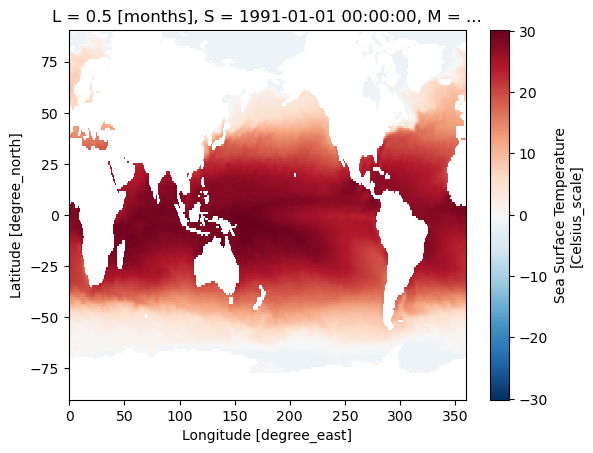

In [9]:
dict_model_hindcast['GFDL-SPEAR'].sst.isel(S=0,M=0,L=0).plot()

```{tip}
`pcolormesh` method generates a map plot that reflects the true value at each grid point. `contour` or `contourf` methods, on the other hand, generate interpolated map plots. It is a personal choice and sometimes depends on the purpose of the plots. However, the `pcolormesh` method would be the best way to represent the actual value in the dataset and not the interpolated result.
```


## Calculate the ensemble mean climatology 
The climatology of the ensemble mean is determined based on two steps.

- Calculate the ensemble mean of all ensemble members in each specific model (in our example `GFDL-SPEAR`)
- Calculate the monthly climatology from the ensemble mean. 

The calculation is based on the hindcast.
If there is more than one model, each model will have its ensemble mean climatology. 
```{important}
For demonstration in this notebook, the climatology period is only based on one year which does not make sense scientifically but this allows users to quickly play around with the data.
For the scientific purpose, the hindcast should at least has 30 years of data to calculate a more meaningful climatology.
```

In [10]:
# one year of data for climatology (demo purpose only)
start_year = 2020
end_year = 2020

The code loop through different models (in this case `GFDL-SPEAR` only), downloads the desired period, calculate the ensemble mean, and calculate the climatology of the ensemble mean.

In [11]:
for nmodel,model in enumerate(model_list):
    print('-------------')
    print(model)
    print('-------------')

    # crop data to the desired period
    with ProgressBar():
        da_model = dict_model_hindcast[model].sst.where(
            (dict_model_hindcast[model]['S.year']>=start_year)&
            (dict_model_hindcast[model]['S.year']<=end_year),
            drop=True).compute()
    
    # calculate ensemble mean
    print('calculate ensemble mean')
    da_ensmean = da_model.mean(dim='M')

    # calculate ensemble mean climatology
    print('calculate climatology')
    da_ensmean_climo = da_ensmean.groupby('S.month').mean(dim='S')

-------------
GFDL-SPEAR
-------------


[                                        ] | 0% Completed | 316.08 us

[                                        ] | 0% Completed | 192.96 ms

[                                        ] | 0% Completed | 303.57 ms

[                                        ] | 0% Completed | 458.64 ms

[                                        ] | 0% Completed | 608.85 ms

[                                        ] | 0% Completed | 727.91 ms

[                                        ] | 0% Completed | 846.13 ms

[                                        ] | 0% Completed | 947.63 ms

[                                        ] | 0% Completed | 1.05 s

[                                        ] | 0% Completed | 1.15 s

[                                        ] | 0% Completed | 1.25 s

[                                        ] | 0% Completed | 1.35 s

[                                        ] | 0% Completed | 1.45 s

[                                        ] | 0% Completed | 1.56 s

[                                        ] | 0% Completed | 1.66 s

[                                        ] | 0% Completed | 1.77 s

[                                        ] | 0% Completed | 1.89 s

[#                                       ] | 3% Completed | 2.02 s

[#                                       ] | 3% Completed | 2.12 s

[#                                       ] | 4% Completed | 2.23 s

[#                                       ] | 4% Completed | 2.33 s

[##                                      ] | 5% Completed | 2.44 s

[##                                      ] | 5% Completed | 2.54 s

[##                                      ] | 5% Completed | 2.64 s

[##                                      ] | 5% Completed | 2.74 s

[##                                      ] | 5% Completed | 2.84 s

[##                                      ] | 5% Completed | 2.94 s

[##                                      ] | 5% Completed | 3.05 s

[##                                      ] | 5% Completed | 3.15 s

[##                                      ] | 5% Completed | 3.25 s

[##                                      ] | 5% Completed | 3.35 s

[##                                      ] | 5% Completed | 3.45 s

[##                                      ] | 6% Completed | 3.57 s

[##                                      ] | 6% Completed | 3.68 s

[###                                     ] | 8% Completed | 3.79 s

[###                                     ] | 9% Completed | 3.90 s

[###                                     ] | 9% Completed | 4.00 s

[####                                    ] | 10% Completed | 4.10 s

[####                                    ] | 10% Completed | 4.21 s

[####                                    ] | 10% Completed | 4.31 s

[####                                    ] | 10% Completed | 4.41 s

[####                                    ] | 10% Completed | 4.51 s

[####                                    ] | 10% Completed | 4.62 s

[####                                    ] | 10% Completed | 4.72 s

[####                                    ] | 10% Completed | 4.82 s

[####                                    ] | 10% Completed | 4.92 s

[####                                    ] | 10% Completed | 5.02 s

[####                                    ] | 10% Completed | 5.12 s

[####                                    ] | 11% Completed | 5.23 s

[####                                    ] | 12% Completed | 5.34 s

[#####                                   ] | 12% Completed | 5.54 s

[#####                                   ] | 14% Completed | 5.68 s

[#####                                   ] | 14% Completed | 5.79 s

[######                                  ] | 15% Completed | 5.89 s

[######                                  ] | 15% Completed | 5.99 s

[######                                  ] | 15% Completed | 6.10 s

[######                                  ] | 15% Completed | 6.20 s

[######                                  ] | 15% Completed | 6.30 s

[######                                  ] | 15% Completed | 6.40 s

[######                                  ] | 15% Completed | 6.50 s

[######                                  ] | 15% Completed | 6.60 s

[######                                  ] | 15% Completed | 6.71 s

[######                                  ] | 15% Completed | 6.81 s

[######                                  ] | 16% Completed | 6.91 s

[######                                  ] | 16% Completed | 7.01 s

[######                                  ] | 16% Completed | 7.12 s

[#######                                 ] | 18% Completed | 7.23 s

[#######                                 ] | 18% Completed | 7.34 s

[#######                                 ] | 19% Completed | 7.45 s

[#######                                 ] | 19% Completed | 7.56 s

[########                                ] | 20% Completed | 7.67 s

[########                                ] | 20% Completed | 7.77 s

[########                                ] | 20% Completed | 7.87 s

[########                                ] | 20% Completed | 7.97 s

[########                                ] | 20% Completed | 8.07 s

[########                                ] | 20% Completed | 8.18 s

[########                                ] | 20% Completed | 8.28 s

[########                                ] | 20% Completed | 8.38 s

[########                                ] | 20% Completed | 8.48 s

[########                                ] | 21% Completed | 8.59 s

[########                                ] | 21% Completed | 8.69 s

[#########                               ] | 22% Completed | 8.82 s

[#########                               ] | 24% Completed | 8.93 s

[#########                               ] | 24% Completed | 9.04 s

[##########                              ] | 25% Completed | 9.14 s

[##########                              ] | 25% Completed | 9.25 s

[##########                              ] | 25% Completed | 9.35 s

[##########                              ] | 25% Completed | 9.45 s

[##########                              ] | 25% Completed | 9.55 s

[##########                              ] | 25% Completed | 9.66 s

[##########                              ] | 25% Completed | 9.76 s

[##########                              ] | 25% Completed | 9.86 s

[##########                              ] | 25% Completed | 9.96 s

[##########                              ] | 25% Completed | 10.06 s

[##########                              ] | 25% Completed | 10.16 s

[##########                              ] | 25% Completed | 10.27 s

[##########                              ] | 25% Completed | 10.37 s

[##########                              ] | 25% Completed | 10.47 s

[##########                              ] | 25% Completed | 10.57 s

[##########                              ] | 25% Completed | 10.67 s

[##########                              ] | 25% Completed | 10.78 s

[##########                              ] | 25% Completed | 10.88 s

[##########                              ] | 26% Completed | 10.98 s

[##########                              ] | 26% Completed | 11.08 s

[##########                              ] | 26% Completed | 11.18 s

[##########                              ] | 26% Completed | 11.29 s

[##########                              ] | 27% Completed | 11.41 s

[###########                             ] | 28% Completed | 11.52 s

[###########                             ] | 29% Completed | 11.62 s

[###########                             ] | 29% Completed | 11.73 s

[############                            ] | 30% Completed | 11.84 s

[############                            ] | 30% Completed | 11.95 s

[############                            ] | 30% Completed | 12.05 s

[############                            ] | 30% Completed | 12.15 s

[############                            ] | 30% Completed | 12.25 s

[############                            ] | 30% Completed | 12.35 s

[############                            ] | 30% Completed | 12.45 s

[############                            ] | 31% Completed | 12.56 s

[############                            ] | 31% Completed | 12.66 s

[############                            ] | 31% Completed | 12.76 s

[############                            ] | 31% Completed | 12.86 s

[############                            ] | 31% Completed | 12.97 s

[#############                           ] | 32% Completed | 13.09 s

[#############                           ] | 34% Completed | 13.20 s

[##############                          ] | 35% Completed | 13.31 s

[##############                          ] | 35% Completed | 13.41 s

[##############                          ] | 36% Completed | 13.53 s

[##############                          ] | 36% Completed | 13.63 s

[##############                          ] | 36% Completed | 13.73 s

[##############                          ] | 36% Completed | 13.83 s

[##############                          ] | 36% Completed | 13.93 s

[##############                          ] | 36% Completed | 14.04 s

[##############                          ] | 36% Completed | 14.14 s

[##############                          ] | 36% Completed | 14.25 s

[##############                          ] | 36% Completed | 14.35 s

[##############                          ] | 36% Completed | 14.45 s

[##############                          ] | 36% Completed | 14.56 s

[##############                          ] | 36% Completed | 14.67 s

[###############                         ] | 38% Completed | 14.77 s

[###############                         ] | 39% Completed | 14.88 s

[################                        ] | 40% Completed | 14.99 s

[################                        ] | 40% Completed | 15.18 s

[################                        ] | 41% Completed | 15.31 s

[################                        ] | 41% Completed | 15.42 s

[################                        ] | 41% Completed | 15.52 s

[################                        ] | 41% Completed | 15.62 s

[################                        ] | 41% Completed | 15.73 s

[################                        ] | 41% Completed | 15.83 s

[################                        ] | 41% Completed | 15.93 s

[################                        ] | 41% Completed | 16.03 s

[################                        ] | 42% Completed | 16.13 s

[#################                       ] | 42% Completed | 16.24 s

[#################                       ] | 43% Completed | 16.34 s

[#################                       ] | 44% Completed | 16.45 s

[#################                       ] | 44% Completed | 16.56 s

[##################                      ] | 45% Completed | 16.67 s

[##################                      ] | 46% Completed | 16.78 s

[##################                      ] | 46% Completed | 16.88 s

[##################                      ] | 46% Completed | 16.98 s

[##################                      ] | 46% Completed | 17.08 s

[##################                      ] | 46% Completed | 17.19 s

[##################                      ] | 46% Completed | 17.29 s

[###################                     ] | 48% Completed | 17.39 s

[###################                     ] | 48% Completed | 17.49 s

[###################                     ] | 49% Completed | 17.59 s

[###################                     ] | 49% Completed | 17.69 s

[###################                     ] | 49% Completed | 17.80 s

[###################                     ] | 49% Completed | 17.90 s

[###################                     ] | 49% Completed | 18.00 s

[###################                     ] | 49% Completed | 18.10 s

[###################                     ] | 49% Completed | 18.20 s

[###################                     ] | 49% Completed | 18.30 s

[###################                     ] | 49% Completed | 18.40 s

[####################                    ] | 50% Completed | 18.50 s

[####################                    ] | 50% Completed | 18.60 s

[####################                    ] | 51% Completed | 18.72 s

[####################                    ] | 51% Completed | 18.83 s

[#####################                   ] | 53% Completed | 18.93 s

[#####################                   ] | 53% Completed | 19.04 s

[#####################                   ] | 54% Completed | 19.15 s

[#####################                   ] | 54% Completed | 19.26 s

[#####################                   ] | 54% Completed | 19.36 s

[#####################                   ] | 54% Completed | 19.46 s

[#####################                   ] | 54% Completed | 19.56 s

[#####################                   ] | 54% Completed | 19.66 s

[######################                  ] | 55% Completed | 19.76 s

[######################                  ] | 56% Completed | 19.87 s

[######################                  ] | 56% Completed | 19.98 s

[######################                  ] | 56% Completed | 20.08 s

[######################                  ] | 56% Completed | 20.18 s

[######################                  ] | 56% Completed | 20.29 s

[######################                  ] | 56% Completed | 20.39 s

[######################                  ] | 56% Completed | 20.49 s

[######################                  ] | 56% Completed | 20.59 s

[######################                  ] | 56% Completed | 20.69 s

[######################                  ] | 56% Completed | 20.79 s

[######################                  ] | 56% Completed | 20.90 s

[######################                  ] | 56% Completed | 21.00 s

[######################                  ] | 56% Completed | 21.10 s

[#######################                 ] | 57% Completed | 21.23 s

[#######################                 ] | 57% Completed | 21.34 s

[#######################                 ] | 59% Completed | 21.47 s

[########################                ] | 60% Completed | 21.58 s

[########################                ] | 60% Completed | 21.69 s

[########################                ] | 61% Completed | 21.81 s

[########################                ] | 61% Completed | 21.91 s

[########################                ] | 61% Completed | 22.01 s

[########################                ] | 61% Completed | 22.14 s

[########################                ] | 61% Completed | 22.25 s

[########################                ] | 61% Completed | 22.36 s

[########################                ] | 61% Completed | 22.46 s

[########################                ] | 61% Completed | 22.56 s

[########################                ] | 61% Completed | 22.66 s

[########################                ] | 61% Completed | 22.76 s

[########################                ] | 62% Completed | 22.86 s

[#########################               ] | 62% Completed | 22.97 s

[#########################               ] | 63% Completed | 23.08 s

[#########################               ] | 63% Completed | 23.20 s

[##########################              ] | 65% Completed | 23.31 s

[##########################              ] | 65% Completed | 23.42 s

[##########################              ] | 66% Completed | 23.54 s

[##########################              ] | 67% Completed | 23.64 s

[##########################              ] | 67% Completed | 23.75 s

[##########################              ] | 67% Completed | 23.85 s

[##########################              ] | 67% Completed | 23.95 s

[##########################              ] | 67% Completed | 24.05 s

[##########################              ] | 67% Completed | 24.16 s

[##########################              ] | 67% Completed | 24.26 s

[##########################              ] | 67% Completed | 24.36 s

[##########################              ] | 67% Completed | 24.46 s

[##########################              ] | 67% Completed | 24.56 s

[###########################             ] | 68% Completed | 24.67 s

[###########################             ] | 68% Completed | 24.78 s

[###########################             ] | 69% Completed | 24.90 s

[############################            ] | 71% Completed | 25.00 s

[############################            ] | 71% Completed | 25.12 s

[############################            ] | 72% Completed | 25.23 s

[#############################           ] | 72% Completed | 25.33 s

[#############################           ] | 72% Completed | 25.43 s

[#############################           ] | 72% Completed | 25.53 s

[#############################           ] | 72% Completed | 25.63 s

[#############################           ] | 72% Completed | 25.73 s

[#############################           ] | 72% Completed | 25.84 s

[#############################           ] | 72% Completed | 25.94 s

[#############################           ] | 72% Completed | 26.05 s

[#############################           ] | 72% Completed | 26.15 s

[#############################           ] | 72% Completed | 26.25 s

[#############################           ] | 73% Completed | 26.35 s

[#############################           ] | 73% Completed | 26.46 s

[#############################           ] | 74% Completed | 26.56 s

[##############################          ] | 75% Completed | 26.75 s

[##############################          ] | 76% Completed | 26.88 s

[##############################          ] | 76% Completed | 26.99 s

[###############################         ] | 77% Completed | 27.09 s

[###############################         ] | 77% Completed | 27.20 s

[###############################         ] | 77% Completed | 27.30 s

[###############################         ] | 78% Completed | 27.40 s

[###############################         ] | 78% Completed | 27.50 s

[###############################         ] | 78% Completed | 27.61 s

[###############################         ] | 78% Completed | 27.71 s

[###############################         ] | 78% Completed | 27.81 s

[###############################         ] | 78% Completed | 27.91 s

[###############################         ] | 78% Completed | 28.01 s

[###############################         ] | 78% Completed | 28.11 s

[###############################         ] | 78% Completed | 28.22 s

[###############################         ] | 78% Completed | 28.33 s

[###############################         ] | 79% Completed | 28.44 s

[################################        ] | 81% Completed | 28.55 s

[#################################       ] | 82% Completed | 28.65 s

[#################################       ] | 82% Completed | 28.77 s

[#################################       ] | 83% Completed | 28.88 s

[#################################       ] | 83% Completed | 28.98 s

[#################################       ] | 83% Completed | 29.08 s

[#################################       ] | 83% Completed | 29.18 s

[#################################       ] | 83% Completed | 29.28 s

[#################################       ] | 83% Completed | 29.38 s

[#################################       ] | 84% Completed | 29.49 s

[##################################      ] | 85% Completed | 29.60 s

[##################################      ] | 85% Completed | 29.70 s

[##################################      ] | 85% Completed | 29.80 s

[##################################      ] | 86% Completed | 29.91 s

[##################################      ] | 86% Completed | 30.01 s

[##################################      ] | 86% Completed | 30.11 s

[##################################      ] | 86% Completed | 30.21 s

[##################################      ] | 86% Completed | 30.31 s

[##################################      ] | 86% Completed | 30.41 s

[##################################      ] | 86% Completed | 30.51 s

[##################################      ] | 86% Completed | 30.61 s

[##################################      ] | 86% Completed | 30.71 s

[##################################      ] | 86% Completed | 30.82 s

[##################################      ] | 87% Completed | 30.92 s

[###################################     ] | 87% Completed | 31.03 s

[###################################     ] | 89% Completed | 31.14 s

[####################################    ] | 90% Completed | 31.24 s

[####################################    ] | 90% Completed | 31.35 s

[####################################    ] | 91% Completed | 31.46 s

[####################################    ] | 91% Completed | 31.56 s

[####################################    ] | 91% Completed | 31.66 s

[####################################    ] | 91% Completed | 31.76 s

[####################################    ] | 91% Completed | 31.87 s

[####################################    ] | 91% Completed | 31.97 s

[####################################    ] | 91% Completed | 32.07 s

[####################################    ] | 91% Completed | 32.17 s

[####################################    ] | 91% Completed | 32.27 s

[####################################    ] | 91% Completed | 32.37 s

[####################################    ] | 91% Completed | 32.47 s

[####################################    ] | 91% Completed | 32.57 s

[####################################    ] | 91% Completed | 32.68 s

[####################################    ] | 91% Completed | 32.78 s

[####################################    ] | 92% Completed | 32.89 s

[#####################################   ] | 93% Completed | 32.99 s

[######################################  ] | 95% Completed | 33.10 s

[######################################  ] | 95% Completed | 33.21 s

[######################################  ] | 96% Completed | 33.32 s

[######################################  ] | 96% Completed | 33.42 s

[######################################  ] | 96% Completed | 33.52 s

[######################################  ] | 96% Completed | 33.63 s

[######################################  ] | 96% Completed | 33.73 s

[######################################  ] | 96% Completed | 33.83 s

[######################################  ] | 96% Completed | 33.93 s

[######################################  ] | 96% Completed | 34.03 s

[######################################  ] | 96% Completed | 34.13 s

[######################################  ] | 96% Completed | 34.23 s

[####################################### ] | 97% Completed | 34.33 s

[########################################] | 100% Completed | 34.44 s

calculate ensemble mean


calculate climatology


```{tip}
Only till this point of the code with `.compute()`, the data is downloaded to the local memory and cropped to our desired period. 
The `ProgressBar()` method provided by the `dask` package gives us a quick way to monitor the progress of the data query in the notebook. 
``` 
To do a quick peak on the calculated `da_ensmean` and `da_ensmean_climo`

In [12]:
da_ensmean

<xarray.DataArray 'sst' (S: 12, L: 12, Y: 181, X: 360)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-1.8152167 , -1.7997636 , -1.8374307 , ..., -1.7942959 ,
          -1.8131804 , -1.8267497 ],
         [-1.8465025 , -1.8499216 , -1.8553926 , ..., -1.8044785 ,
          -1.8234142 , -1.8409054 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [-0.40647423, -0.32241496, -0.32639506, ..., -1.2913983 ,
          -1.0387492 , -0.67631894],
         [-0.53427947, -0.25783926, -0.15042621, ..., -1.2976335 ,
          -1.157531  , -0.9127232 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-1.3329976 , -1.2299353 , -1.227057  , ..., -1.6917287 ,
          -1.6293875 , -1.4921345 ],
         [-1.4859961 , -1.4001585 , -1.3600676 , ..., -1.7011333 ,
          -1.6687951 , -1.5964279 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) object 2020-01-01 00:00:00 ... 2020-12-01 00:00:00
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

In [13]:
da_ensmean_climo

<xarray.DataArray 'sst' (month: 12, L: 12, Y: 181, X: 360)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-1.8152167 , -1.7997636 , -1.8374307 , ..., -1.7942959 ,
          -1.8131804 , -1.8267497 ],
         [-1.8465025 , -1.8499216 , -1.8553926 , ..., -1.8044785 ,
          -1.8234142 , -1.8409054 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [-0.40647423, -0.32241496, -0.32639506, ..., -1.2913983 ,
          -1.0387492 , -0.67631894],
         [-0.53427947, -0.25783926, -0.15042621, ..., -1.2976335 ,
          -1.157531  , -0.9127232 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-1.3329976 , -1.2299353 , -1.227057  , ..., -1.6917287 ,
          -1.6293875 , -1.4921345 ],
         [-1.4859961 , -1.4001585 , -1.3600676 , ..., -1.7011333 ,
          -1.6687951 , -1.5964279 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

We can see the `da_ensmean` has one dimension less than the original dataset due to the ensemble member dimension `M` being averaged. 
The `da_ensmean_climo`, on the other hand, is grouped by the month of the year.


## Calculate the threshold
The monthly threshold is based on the hindcast SST anomaly with a three-month window (initial months) for each initial time (centered month) and associated lead time.
```{admonition} Example:
The January (initial month) threshold of lead time = 0.5,1.5,2.5,... month is determined by all ensemble members with December, January, and February SST anomaly at lead time = 0.5,1.5,2.5,... month, respectively. 
```
### Define functions 
The function below performs the three-month window on all initial months to find the corresponding monthly threshold at each lead time.

In [14]:
def nmme_3mon_quantile(da_data, mhw_threshold=90.):
    """
    This function is designed for calculating the nmme 
    marine heat wave threshold.
    
    The threshold is calculated using a 3 month window
    to identified the X quantile value for each month.

    Parameters
    ----------
    da_data : xr.DataArray 
        For marine heat wave calculation, it should be the sst DataArray. 
        Since this function is designed for NMME model. The DataArray need 
        to be in the format of NMME model output.
    mhw_threshold : float
        the X quantile one wants to calculate. 

    Returns
    -------
    da_data_quantile : xr.DataArray
        The xr.DataArray for the quantile 

    Raises
    ------

    """
    
    da_data_quantile = xr.DataArray(coords={'X':da_data.X,
                                            'Y':da_data.Y,
                                            'month':np.arange(1,13),
                                            'L':da_data.L},
                                    dims = ['month','L','Y','X'])

    for i in range(1,13):
        print(f"calculate month{i} threshold")
        if i == 1:
            mon_range = [12,1,2]
        elif i == 12 :
            mon_range = [11,12,1]
        else:
            mon_range = [i-1,i,i+1]

        da_data_quantile[i-1,:,:,:] = (da_data
                                 .where((da_data['S.month'] == mon_range[0])|
                                        (da_data['S.month'] == mon_range[1])|
                                        (da_data['S.month'] == mon_range[2]),drop=True)
                                 .stack(allens=('S','M'))
                                 .quantile(mhw_threshold*0.01, dim = 'allens', method='linear',skipna = True))

    return da_data_quantile
    


            

With the function defined, we just need to calculate the SST anomaly in hindcast.
There are different methods to determine the quantile. 
For `xarray.quantile` method (based on `numpy.quantile`), one can choose the desired method based on [NumPy documentation](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html#numpy.quantile).

In [15]:
print('calculating anomaly from hindcast')
da_anom = (da_model.groupby('S.month') - da_ensmean_climo)

ds_mhw_threshold = xr.Dataset()

mhw_threshold = [90]
for m in mhw_threshold:

    print(f'calculating threshold {m}')
    da_threshold = nmme_3mon_quantile(da_anom, mhw_threshold=m)
    ds_mhw_threshold[f'threshold_{m}'] = da_threshold

calculating anomaly from hindcast
calculating threshold 90
calculate month1 threshold


calculate month2 threshold


calculate month3 threshold


calculate month4 threshold


calculate month5 threshold


calculate month6 threshold


calculate month7 threshold


calculate month8 threshold


calculate month9 threshold


calculate month10 threshold


calculate month11 threshold


calculate month12 threshold


```{warning}
The function `nmme_3mon_quantile` is the most time-consuming part of the whole calculation. 
It should have a more optimal way to speed up the process. 
However, this is currently (at the time of creating this notebook) our best solution.
```
The resulting threshold structure would look like below

In [16]:
da_threshold

<xarray.DataArray (month: 12, L: 12, Y: 181, X: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.03974178, 0.03800244, 0.0391201 , ..., 0.02901187,
          0.02458122, 0.02564578],
         [0.02360184, 0.02258537, 0.02060158, ..., 0.02521191,
          0.02393916, 0.02910042],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [0.72357243, 0.6991505 , 0.60478079, ..., 0.4973405 ,
          0.57291734, 0.64648652],
         [0.71915537, 0.69076586, 0.86227494, ..., 0.52292567,
          0.60902071, 0.7330662 ],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.48410219, 0.40909404, 0.44498792, ..., 0.18629833,
          0.25511676, 0.40680373],
         [0.58163875, 0.57490486, 0.68392879, ..., 0.13991448,
          0.22305867, 0.47826964],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5

## Calculate the anomaly of forecast

### Load one initial time of forecast anomaly data for demo

In [17]:
for nmodel,model in enumerate(model_list):
    print('-------------')
    print(model)
    print('-------------')

    # crop data to the desired period
    with ProgressBar():
        da_model_forecast = dict_model_forecast[model].sst.sel(S="2022-01").compute()
        
print('calculating anomaly from forecast')
da_model_forecast = da_model_forecast.groupby('S.month') - da_ensmean_climo

-------------
GFDL-SPEAR
-------------
[                                        ] | 0% Completed | 294.04 us

[                                        ] | 0% Completed | 113.38 ms

[                                        ] | 0% Completed | 257.39 ms

[                                        ] | 0% Completed | 364.15 ms

[                                        ] | 0% Completed | 465.81 ms

[                                        ] | 0% Completed | 566.91 ms

[                                        ] | 0% Completed | 668.32 ms

[                                        ] | 0% Completed | 774.60 ms

[                                        ] | 0% Completed | 879.68 ms

[                                        ] | 0% Completed | 980.46 ms

[                                        ] | 0% Completed | 1.08 s

[#                                       ] | 3% Completed | 1.19 s

[#                                       ] | 4% Completed | 1.31 s

[#######                                 ] | 17% Completed | 1.43 s

[########                                ] | 20% Completed | 1.55 s

[#########                               ] | 23% Completed | 1.65 s

[##########                              ] | 27% Completed | 1.76 s

[############                            ] | 30% Completed | 1.87 s

[#############                           ] | 34% Completed | 1.97 s

[##############                          ] | 36% Completed | 2.08 s

[###############                         ] | 39% Completed | 2.18 s

[#################                       ] | 42% Completed | 2.29 s

[###################                     ] | 48% Completed | 2.40 s

[####################                    ] | 51% Completed | 2.51 s

[#####################                   ] | 54% Completed | 2.64 s

[########################                ] | 60% Completed | 2.74 s

[#########################               ] | 64% Completed | 2.86 s

[###########################             ] | 67% Completed | 2.97 s

[############################            ] | 71% Completed | 3.09 s

[#################################       ] | 83% Completed | 3.20 s

[###################################     ] | 88% Completed | 3.31 s

[####################################    ] | 91% Completed | 3.41 s

[######################################  ] | 95% Completed | 3.51 s

[########################################] | 100% Completed | 3.61 s

calculating anomaly from forecast


Here, we only pick one initial time to download. 
For each initial time (`S`), there are 11 lead times (`L`) and 30 ensemble members (`M`) in NMME. 
The SST anomaly of the forecast is determined by subtracting the ensemble mean climatology that we calculated based on hindcast. 


## Calculate the marine heatwave 
Using the forecast SST anomaly and the threshold determined based on the hindcast, we can identify the marine heatwave in the forecast.

In [18]:
ds_mhw = xr.Dataset()

for m in mhw_threshold:

    print(f'calculating MHW {m}')
    da_mhw = da_model_forecast.where(da_model_forecast.groupby('S.month')>=ds_mhw_threshold[f'threshold_{m}'])
    ds_mhw[f'mhw_{m}'] = da_mhw

calculating MHW 90


The result is stored in the `xarray.Dataset` with the variable name `mhw_90`.
All grid points with SST anomaly higher than the corresponding threshold are original values preserved. 
The place that has a value lower than the threshold will be masked with `NaN`.

In [19]:
da_mhw

<xarray.DataArray 'sst' (S: 1, L: 12, M: 30, Y: 181, X: 360)>
array([[[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
           0.02415383, 0.029356  ],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],

         [[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
...
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],

         [[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ..., 0.05839467,
           0.05956662, 0.05180919],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]]]]], dtype=float32)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) object 2022-01-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 26.0 27.0 28.0 29.0 30.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
    month    (S) int64 1

## Show result

For the following paragraph, we will start showing some map plot which is used to check if the calculation performed above make sense. 

### Define plot format function
```{tip}
When producing multiple maps for comparison, we often time like to keep maps in the same format. 
To avoid repetition of format-related code, it is good practice to define a function that handles the format. 
This way the same format will be applied to all plots that call the function.
```

In [20]:
def plot_format(ax,font_size=10):
    ax.coastlines(resolution='110m',linewidths=0.8)
    ax.add_feature(cfeature.LAND,color='lightgrey')

    ax.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=font_size)
    ax.set_yticks([-90,-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_yticklabels([-90,-60,-30,0,30,60,90], color='black', weight='bold',size=font_size)
    ax.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('auto')
    
    return ax

### Show threshold, MHW, and SST anomaly

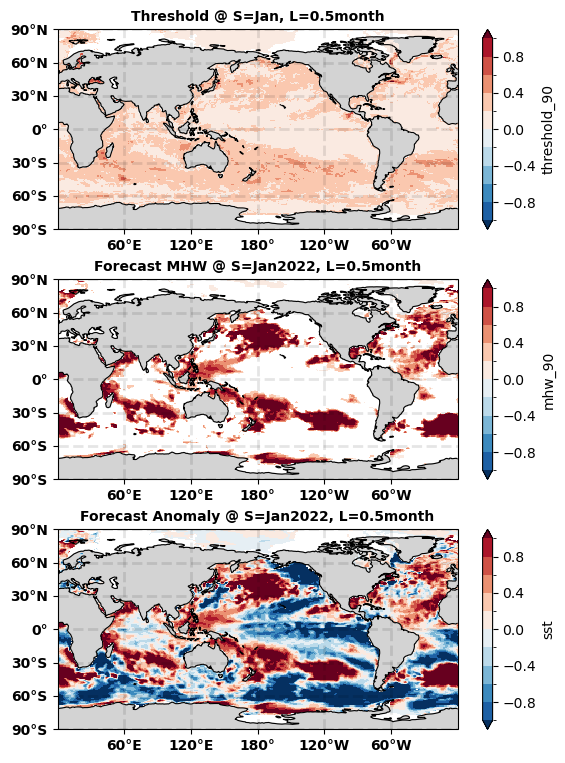

In [21]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(10,10))
fontsize = 10
level = np.linspace(-1, 1, 11)

# threshold figure
ax2 = fig.add_axes([0,0.5,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))
im = (
    ds_mhw_threshold
        .isel(month=0,L=0).threshold_90
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax2, 
            levels=level, 
            extend='both', 
            cmap='RdBu_r',
            transform=ccrs.PlateCarree(central_longitude=0)
        )
)
ax2.set_title('Threshold @ S=Jan, L=0.5month', color='black', weight='bold',size=fontsize)
ax2 = plot_format(ax2,font_size=fontsize)


# mhw figure
ax3 = fig.add_axes([0,0.25,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))
im = (
    ds_mhw
        .isel(S=0,L=0,M=0).mhw_90
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax3, 
            levels=level, 
            extend='both', 
            cmap='RdBu_r',
            transform=ccrs.PlateCarree(central_longitude=0)
        )
)
ax3.set_title('Forecast MHW @ S=Jan2022, L=0.5month', color='black', weight='bold',size=fontsize)
ax3 = plot_format(ax3,font_size=fontsize)

# anomaly figure
ax4 = fig.add_axes([0,0,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))
im = (
    da_model_forecast
        .isel(S=0,L=0,M=0)
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax4, 
            levels=level, 
            extend='both', 
            cmap='RdBu_r',
            transform=ccrs.PlateCarree(central_longitude=0)
        )
)
ax4.set_title('Forecast Anomaly @ S=Jan2022, L=0.5month', color='black', weight='bold',size=fontsize)
ax4 = plot_format(ax4,font_size=fontsize)


The first map above shows the threshold for initial time = January and lead time = 0.5month. The second map shows the marine heatwave detected in the NMME SST forecast at initial time = Jan 2022 and lead time = 0.5month. The third map shows the original NMME SST forecast at initial time = Jan2022 and lead time = 0.5month.

Comparison between the first and second maps shows that all identified marine heatwave signals (second map) are all higher than the threshold (first map). 
Comparison between the second and third maps shows that all masked regions (second map) values lower than the threshold (first map).



### calculate MHW event
After the quick senitiy check, we can  
- Assign Not a Number to masked our region (as no MHW)
- Assign 1 to regions with values (as MHW exist)
in `ds_mhw`

In [22]:
da_mhw_event = (ds_mhw.isel(S=0,L=11).mhw_90/ds_mhw.isel(S=0,L=11).mhw_90)

Here, we picked lead time = 11.5 months to demonstrate the result of marine heatwave identification.

In [23]:
da_mhw_event.max()

<xarray.DataArray 'mhw_90' ()>
array(1., dtype=float32)
Coordinates:
    L        float32 11.5
    S        object 2022-01-01 00:00:00
    month    int64 1

As you can see from the result above that the maximum value is now `1` indicating the existence of a marine heatwave.


### Show all enesemble member identified MHW 
To show how different ensemble members can have very different results, we use the `.plot()` method without much formatting for a quick view of the variation between members.
```{note}
The following figures are for a specific start time (S = 2022 Jan) and lead time (11.5 months = 2022 Dec)
```

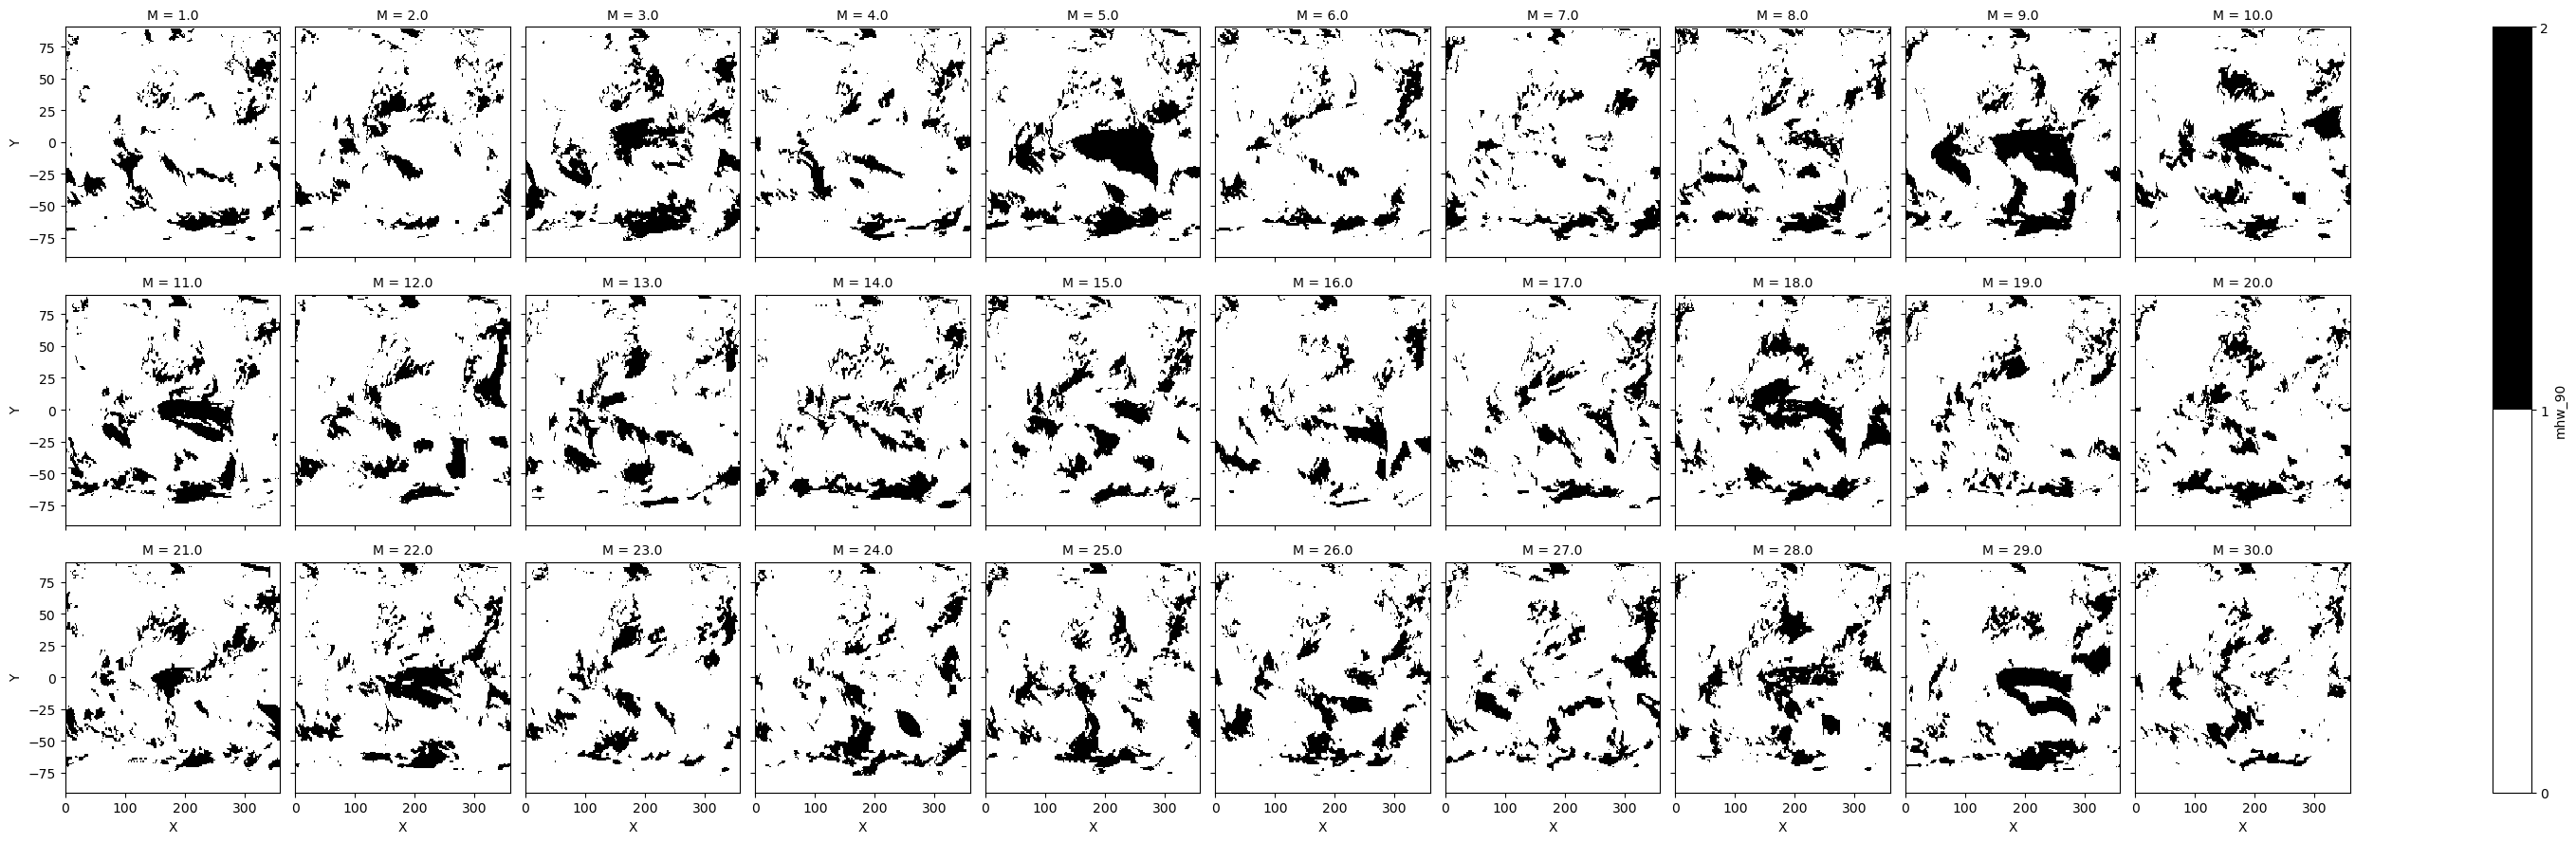

In [24]:
da_landmask = da_model_forecast.isel(L=0,M=0,S=0)/da_model_forecast.isel(L=0,M=0,S=0)
da_mhw_event.plot(x="X",y='Y',col='M',col_wrap=10,cmap='Greys',levels=np.arange(0,2+1))

### Show total identified MHW in ensemble and associated probability
By summing up all the ensemble members' results in `da_mhw_event`, we know at a specific start time (S = 2022 Jan), lead time (11.5 months = 2022 Dec), and grid point how many ensemble members have predicted the existence of marine heatwaves.
We divide this total number of marine heatwaves by the total number of ensemble members to produce the probability(%) of marine heatwaves in the forecast.
```{important}
By doing the same calculation for a different model which also has its ensemble members, we can combine the total number of marine heatwaves from across models to get a probability forecast that considers the variations between different models.  
```

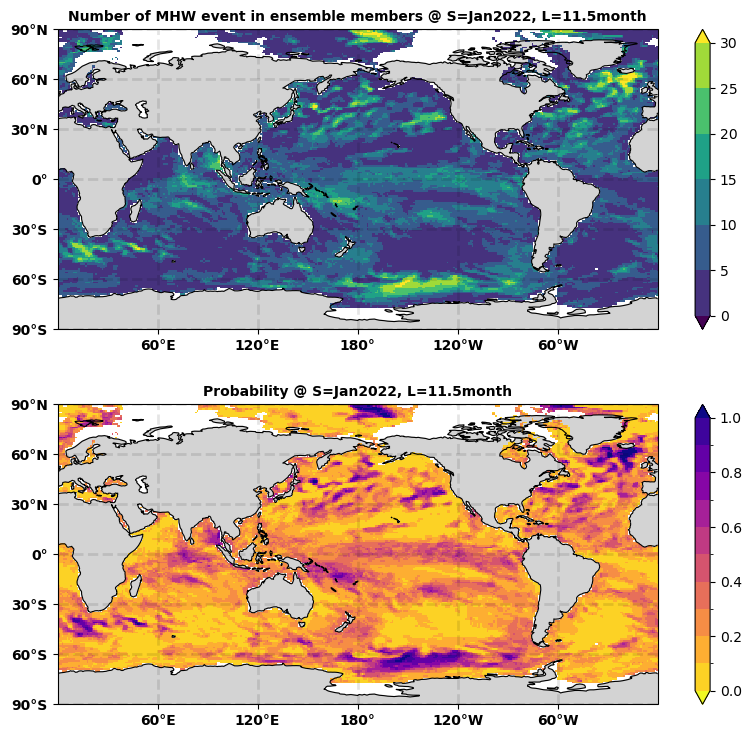

In [25]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(15,15))
fontsize = 10
num_level = np.arange(0, 30+1, 5)
level = np.arange(0, 1+0.1, 0.1)

# mhw event figure
ax2 = fig.add_axes([0,0.5,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))
im = (
    (da_mhw_event.sum(dim='M')*da_landmask)
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax2, 
            levels=num_level, 
            extend='both', 
            cmap='viridis',
            transform=ccrs.PlateCarree(central_longitude=0)
        )
)
ax2.set_title('Number of MHW event in ensemble members @ S=Jan2022, L=11.5month', color='black', weight='bold',size=fontsize)
ax2 = plot_format(ax2,font_size=fontsize)

# mhw probability figure
ax3 = fig.add_axes([0,0.25,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))
im = (
    (da_mhw_event.sum(dim='M')/da_mhw_event.M.max()*da_landmask)
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax3, 
            levels=level, 
            extend='both', 
            cmap='plasma_r',
            transform=ccrs.PlateCarree(central_longitude=0)
        )
)
ax3.set_title('Probability @ S=Jan2022, L=11.5month', color='black', weight='bold',size=fontsize)
ax3 = plot_format(ax3,font_size=fontsize)

The first map above shows the total number of marine heatwave events in all 30 members of members from `GFDL-SPEAR` at initial time = January 2022 and lead time = 11.5month. The second map shows the probability of marine heatwave based on the NMME SST forecast at initial time = January 2022 and lead time = 11.5month. The second map is determined by dividing 30 on the first map.